In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import pickle
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
from skimage.io import imread
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.model_selection import  cross_val_score
# The two discriminant methods below support multiclass
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [4]:
def create_graph():
    with gfile.FastGFile('inception-2015-12-05/classify_image_graph_def.pb', 'rb') as f: #modify the path of the pb file here
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
def extract_features_moving_window(image_data): #image_data is np array
    create_graph() #necessary for getting tensors

    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        predictions = sess.run(next_to_last_tensor, {'DecodeJpeg:0': image_data})
        return np.squeeze(predictions).reshape(1,-1)

def moving_windows(image,lda): #very big complexity, it's more efficient to run on server!!
    result = {}
    h,w,_ = image.shape
    index=1
    for x in range(0,h-64,64):
        for y in range(0,w-64,64):
            print(index," th moving window")
            index=index+1
            block = image[x:x+65,y:y+65,:]
            feature = extract_features_moving_window(block)
            if feature is None:
                continue
            else:
                res = lda.predict_proba(feature)[0,0]
                if res > 0.9:
                    result[(x,y)]=1    
    return result

def drawVirtrualBox2(image, res):
    for k,v in res.items():
        if v==0:
            continue
        x,y = k
        maxy, maxx, minx, miny = y + 64, x + 128, x, y
        for k1 in res.keys():
            x1,y1 = k1
            if minx<=x1<=maxx and miny<=y1<=maxy or miny<=y1+64<=maxy:
                res[k1]=0
                maxy = max(maxy, y1+64)
                maxx = max(maxx, x1+128)
                miny = min(miny, y1)
                minx = min(minx, x1)
        cv2.rectangle(image, (miny,minx), (maxy,maxx), (255, 1, 2), 2)
    cv2.imshow("result", image)
    #cv2.waitKey()


In [6]:
extracted_features = pd.read_pickle("crmo-diagnosis-using-mri/inception/inception_cnn_features_Qingjie_Johnathan.pkl") #put here the path of pkl I've uploaded on github
X=extracted_features.values
labels=[]
for i in range(48):
    labels.append(1 if extracted_features.index[i][-1]=='+' else 0)
labels=np.array(labels)

In [7]:
#Scale data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

#Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42,stratify=labels)


In [8]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

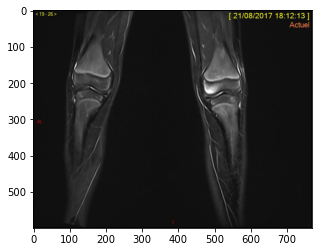

In [10]:
test_image_array=imread("crmo-diagnosis-using-mri/legs_folder_jpg_cnn_Qingjie/7TK_OCMR+.jpg") #put here the path of one positive image
plt.imshow(test_image_array)

In [ ]:
t0 = time()
res=moving_windows(test_image_array,lda)
drawVirtrualBox2(test_image_array, res)
print("done in %0.3fs" % (time() - t0))